In [45]:
import matplotlib.pyplot as plt
import numpy as np

def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

def tonegen(freq: float,
            duration: float,
            amplitude: float,
            samplefreq: float
            ) -> np.ndarray:
    '''
    Generates a sinewave with the given parameters
    '''
    samples = int(duration * samplefreq)
    t = np.linspace(0., duration, samples)
    tone = amplitude * np.sin(2. * np.pi * freq * t)
    return tone

def plotfreqz(b, a, label, Fs):
    from scipy.signal import freqz
    w, h = freqz(b, a, worN=2**12)
    fig, ax1 = plt.subplots(figsize=(11, 4))
    ax1.set_title(label + ' - Frequency  Response for N=' + str(len(b)))
    f = Fs * w / (2 * np.pi)
    ax1.plot(f, 20 * np.log10(abs(h)), label="Gain")
    ax1.set_ylabel('Gain [dB]')
    ax1.set_xlabel('Frequency [Hz]')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(f, angles, '--', label="Phase")
    ax2.set_ylabel('Phase [rad/s]')
    ax2.grid()
    ax2.axis('tight')
    fig.legend()
    plt.show()
    
def create_lpf_FIR(numtaps: float, cutoff: float, plot=False, verbose=False):
    from scipy.signal import firwin
    fs = 24000
    window = 'hann'
    b = firwin(numtaps, cutoff, window=window,fs=fs)
    a = 1
    if plot:
        plotfreqz(b, a, f"{'hanning'} {'lowpass'}", fs)
    if verbose:
        print(f"FIR coeff b[{len(b)}]:\n{b}")
    return b

def create_lpf_IIR(numtaps: float, cutoff: float, plot=False, verbose=False):
    from scipy.signal import iirfilter
    fs=24000
    ftype = 'butter'
    btype = 'lowpass'
    b, a = iirfilter(numtaps, cutoff, ftype=ftype, btype=btype, fs=fs)
    if plot:
        plotfreqz(b, a, f"{btype} {ftype}", fs)
    if verbose:
        print(f"IIR coeff b[{len(b)}]:\n{b}")
        print(f"IIR coeff a[{len(a)}]:\n{a}")
    return b, a

def true_RMS(input: np.array) -> float:
    return np.sqrt(sum(n*n for n in input)/len(input))
                  
@static_vars(n=0, sum=0, buffer=[0]*100)
def compute_SMA(input: float, length: int) -> float:
    
    compute_SMA.sum += (input -compute_SMA.buffer[compute_SMA.n])
    compute_SMA.buffer[compute_SMA.n] = input
    
    compute_SMA.n += 1
    if compute_SMA.n >= length:
        compute_SMA.n = 0
    
    return compute_SMA.sum/length

@static_vars(n=0, sum=0)
def compute_RMA(input: float, length: int) -> float:
    if compute_RMA.n < length:
        compute_RMA.n += 1
        
    compute_RMA.sum = ((compute_RMA.n -1)*compute_RMA.sum + input)/compute_RMA.n    
    return compute_RMA.sum

@static_vars(sum=0)
def compute_fixed_length_RMA(input: float, length: int) -> float:
    compute_fixed_length_RMA.sum = ((length -1)*compute_fixed_length_RMA.sum + input)/length   
    return compute_fixed_length_RMA.sum

@static_vars(n=0, sum=0)
def compute_CMA(input: float, reset=False) -> float:
    if reset:
        compute_CMA.n = 0;
        compute_CMA.sum = 0;
        return 0

    compute_CMA.n += 1;
    compute_CMA.sum += (input -compute_CMA.sum)/compute_CMA.n
    
    return compute_CMA.sum

@static_vars(n=0, sum=0)
def compute_EMA(input: float, length: int) -> float:
    if compute_EMA.n < length:
        compute_EMA.n += 1

    compute_EMA.sum += (input -compute_EMA.sum)/compute_EMA.n
    
    return compute_EMA.sum

@static_vars(sum=0)
def compute_fixed_length_EMA(input: float, length: int) -> float:
    compute_fixed_length_EMA.sum += (input -compute_fixed_length_EMA.sum)/length
    
    return compute_fixed_length_EMA.sum

@static_vars(n=0, sum=0, avg=0)
def compute_simple_average(input: float, length: int) -> float:
    compute_simple_average.sum += input
    compute_simple_average.n += 1
    
    if compute_simple_average.n >= length:
        compute_simple_average.avg = compute_simple_average.sum / length
        compute_simple_average.sum = 0
        compute_simple_average.n = 0
    
    return compute_simple_average.avg

@static_vars(input_buffer=[0]*50, b=None, n=0, debug=False)
def compute_FIR(input: float, verbose=False, plot=False, debug=False, reset=False, numtaps=None) -> float:
    """
    A Ring Buffer FIR implementation
    ref: https://www.youtube.com/watch?v=fdCAsZkjpSg
    """              
    if reset is True:
        compute_FIR.input_buffer=[0]*50
        compute_FIR.b=None
        compute_FIR.n=0
        return 0
    
    compute_FIR.debug = debug
                  
    if numtaps is None:
        numtaps=25

    if compute_FIR.b is None:
        compute_FIR.b = create_lpf_FIR(numtaps=numtaps, cutoff=600, plot=plot, verbose=verbose)
    
    compute_FIR.input_buffer[compute_FIR.n] = input
    output = 0
    
    k = 0
    n = compute_FIR.n
    if compute_FIR.debug:
        print(f"\n\t y[{n}] =", end='')
    while n >= 0:
        if compute_FIR.debug:
            print(f" +b[{k}]*x[{n}]", end='')
        output += compute_FIR.b[k] * compute_FIR.input_buffer[n]
        k += 1
        n -= 1
        
    n = numtaps -1
    while n > compute_FIR.n:
        if compute_FIR.debug:
            print(f" +b[{k}]*x[{n}]", end='')
        output += compute_FIR.b[k] * compute_FIR.input_buffer[n]
        k += 1
        n -= 1
    
    compute_FIR.n += 1
    if compute_FIR.n >= numtaps:
        compute_FIR.n = 0
        if compute_FIR.debug:
            compute_FIR.debug = False
            print()

    return output

@static_vars(input_buffer=[0]*100, output_buffer=[0]*100, a=None, b=None, n=0, debug=False)
def compute_IIR(input: float, verbose=False, plot=False, debug=False, reset=False, numtaps=None) -> float:
    if reset is True:
        compute_IIR.input_buffer=[0]*50
        compute_IIR.output_buffer=[0]*50
        compute_IIR.b=None
        compute_IIR.a=None
        compute_IIR.n=0
        return 0

    compute_IIR.debug = debug
                  
    if numtaps is None:
        numtaps = 5

    if (compute_IIR.b is None) or (compute_IIR.a is None):
        compute_IIR.b, compute_IIR.a = create_lpf_IIR(numtaps-1, cutoff=600, plot=plot, verbose=verbose)

    compute_IIR.input_buffer[compute_IIR.n] = input
    output = 0
    
    k = 0
    n = compute_IIR.n
    
    if compute_IIR.debug:
        print(f"\n\t y[{n}] = +b[{k}]*x[{n}]", end='')
    output = compute_IIR.b[k]*compute_IIR.input_buffer[compute_IIR.n]

    while n > 0:
        k += 1
        n -= 1
        if compute_IIR.debug:
            print(f" +b[{k}]*x[{n}] -a[{k}]*y[{n}]", end='')
        output += compute_IIR.b[k]*compute_IIR.input_buffer[n]
        output -= compute_IIR.a[k]*compute_IIR.output_buffer[n]
        
    
    n = numtaps-1
    while n > compute_IIR.n:
        k += 1
        if compute_IIR.debug:
            print(f" +b[{k}]*x[{n}] -a[{k}]*y[{n}]", end='')
        output += compute_IIR.b[k]*compute_IIR.input_buffer[n]
        output -= compute_IIR.a[k]*compute_IIR.output_buffer[n]
        n -= 1
        
    compute_IIR.output_buffer[compute_IIR.n] = output
    
    compute_IIR.n += 1
    if compute_IIR.n >= numtaps:
        compute_IIR.n = 0
        compute_IIR.debug = False

    return output

@static_vars(n=0, sum=0, buffer=[0]*1600)
def compute_true_RMS(input: float, length=24000/60, reset=False) -> float:
    if reset is True:
        compute_true_RMS.n = 0
        compute_true_RMS.sum = 0
        compute_true_RMS.buffer=[0]*1600
        return 0
                  
    compute_true_RMS.sum -= compute_true_RMS.buffer[compute_true_RMS.n]
    compute_true_RMS.buffer[compute_true_RMS.n] = input*input
    compute_true_RMS.sum += compute_true_RMS.buffer[compute_true_RMS.n]
    
    output = np.sqrt(compute_true_RMS.sum/length)
    
    compute_true_RMS.n += 1
    if compute_true_RMS.n >= length:
        compute_true_RMS.n = 0
    
    return output


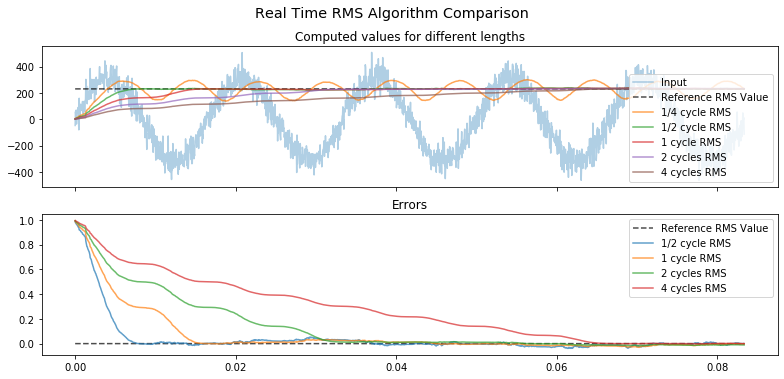

<Figure size 432x288 with 0 Axes>

In [49]:
def RMS_test():
    # generate sin wave data
    periods = 5
    amplitude = 220*np.sqrt(2)
    frequency = 60
    duration = periods / frequency
    noise_percentage = (20/100)*amplitude
    sample_frequency = 24000
    ydata = tonegen(frequency, duration, amplitude, sample_frequency)
    xdata = np.linspace(0., ydata.size / sample_frequency, ydata.size)
    # add noise to the data
    ydata += np.random.normal(0, noise_percentage, len(ydata))
    
    output_true_RMS_025 = np.zeros(len(xdata))
    output_true_RMS_05 = np.zeros(len(xdata))
    output_true_RMS_1 = np.zeros(len(xdata))
    output_true_RMS_2 = np.zeros(len(xdata))
    output_true_RMS_4 = np.zeros(len(xdata))
    output_true_RMS_ref = np.ones(len(xdata)) * true_RMS(ydata)
    
    compute_true_RMS(0, reset=True)
    for i, y in enumerate(ydata):
        output_true_RMS_025[i] = compute_true_RMS(y, 0.25*24000/60)
    compute_true_RMS(0, reset=True)
    for i, y in enumerate(ydata):
        output_true_RMS_05[i] = compute_true_RMS(y, 0.5*24000/60)
    compute_true_RMS(0, reset=True)
    for i, y in enumerate(ydata):
        output_true_RMS_1[i] = compute_true_RMS(y, 1*24000/60)
    compute_true_RMS(0, reset=True)
    for i, y in enumerate(ydata):
        output_true_RMS_2[i] = compute_true_RMS(y, 2*24000/60)
    compute_true_RMS(0, reset=True)
    for i, y in enumerate(ydata):
        output_true_RMS_4[i] = compute_true_RMS(y, 4*24000/60)

    error_true_RMS_025 = (output_true_RMS_ref -output_true_RMS_025)/output_true_RMS_ref
    error_true_RMS_05 = (output_true_RMS_ref -output_true_RMS_05)/output_true_RMS_ref
    error_true_RMS_1 = (output_true_RMS_ref -output_true_RMS_1)/output_true_RMS_ref
    error_true_RMS_2 = (output_true_RMS_ref -output_true_RMS_2)/output_true_RMS_ref
    error_true_RMS_4 = (output_true_RMS_ref -output_true_RMS_4)/output_true_RMS_ref
        
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11,11/2), sharex=True)
    st = fig.suptitle(f"Real Time RMS Algorithm Comparison", fontsize="x-large")
    ax1.set_title("Computed values for different lengths")
    ax1.plot(xdata, ydata, label="Input", alpha=0.7*0.5)
    ax1.plot(xdata, output_true_RMS_ref, 'k--', label="Reference RMS Value", alpha=0.7)
    ax1.plot(xdata, output_true_RMS_025, label="1/4 cycle RMS", alpha=0.7)
    ax1.plot(xdata, output_true_RMS_05, label="1/2 cycle RMS", alpha=0.7)
    ax1.plot(xdata, output_true_RMS_1, label="1 cycle RMS", alpha=0.7)
    ax1.plot(xdata, output_true_RMS_2, label="2 cycles RMS", alpha=0.7)
    ax1.plot(xdata, output_true_RMS_4, label="4 cycles RMS", alpha=0.7)
    ax1.legend(loc='lower right')
    
    ax2.set_title("Errors")
    ax2.plot(xdata, np.zeros(len(xdata)), 'k--', label="Reference RMS Value", alpha=0.7)
#     ax2.plot(xdata, error_true_RMS_025, label="1/4 cycle RMS", alpha=0.7)
    ax2.plot(xdata, error_true_RMS_05, label="1/2 cycle RMS", alpha=0.7)
    ax2.plot(xdata, error_true_RMS_1, label="1 cycle RMS", alpha=0.7)
    ax2.plot(xdata, error_true_RMS_2, label="2 cycles RMS", alpha=0.7)
    ax2.plot(xdata, error_true_RMS_4, label="4 cycles RMS", alpha=0.7)
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    # shift subplots down:
    st.set_y(0.95)
    fig.subplots_adjust(top=0.85)
    plt.show()
    plt.savefig('real_time_rms_algorithm_comparison.png')
    
RMS_test()

		Ring Buffer FIR:

	 y[0] = +b[0]*x[0] +b[1]*x[4] +b[2]*x[3] +b[3]*x[2] +b[4]*x[1]
	 y[1] = +b[0]*x[1] +b[1]*x[0] +b[2]*x[4] +b[3]*x[3] +b[4]*x[2]
	 y[2] = +b[0]*x[2] +b[1]*x[1] +b[2]*x[0] +b[3]*x[4] +b[4]*x[3]
	 y[3] = +b[0]*x[3] +b[1]*x[2] +b[2]*x[1] +b[3]*x[0] +b[4]*x[4]
	 y[4] = +b[0]*x[4] +b[1]*x[3] +b[2]*x[2] +b[3]*x[1] +b[4]*x[0]


		Ring Buffer IIR:

	 y[0] = +b[0]*x[0] +b[1]*x[2] -a[1]*y[2] +b[2]*x[1] -a[2]*y[1]
	 y[1] = +b[0]*x[1] +b[1]*x[0] -a[1]*y[0] +b[2]*x[2] -a[2]*y[2]
	 y[2] = +b[0]*x[2] +b[1]*x[1] -a[1]*y[1] +b[2]*x[0] -a[2]*y[0]

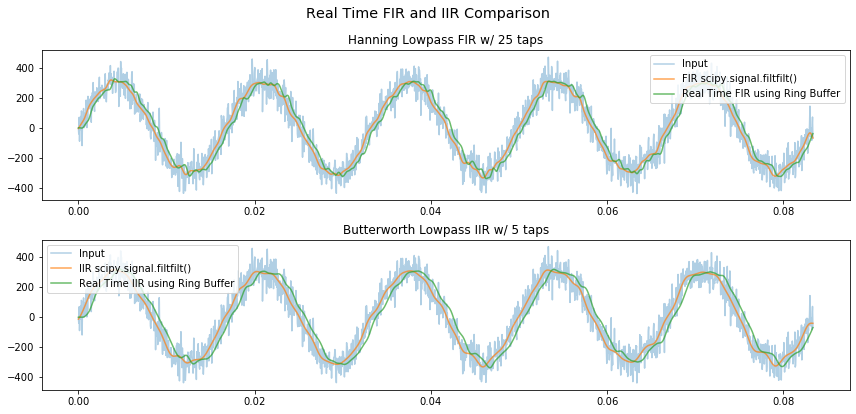

<Figure size 432x288 with 0 Axes>

In [50]:
def FIR_IIR_test():
    # generate sin wave data
    periods = 5
    amplitude = 220*np.sqrt(2)
    frequency = 60
    duration = periods / frequency
    noise_percentage = (20/100)*amplitude
    sample_frequency = 24000
    ydata = tonegen(frequency, duration, amplitude, sample_frequency)
    xdata = np.linspace(0., ydata.size / sample_frequency, ydata.size)
    # add noise to the data
    ydata += np.random.normal(0, noise_percentage, len(ydata))

    output_FIR = np.zeros(len(xdata))
    output_IIR = np.zeros(len(xdata))
    compute_FIR(0, reset=True)
    compute_IIR(0, reset=True)
    for i,y in enumerate(ydata):
        output_FIR[i] = compute_FIR(y)
        output_IIR[i] = compute_IIR(y)
    
    from scipy.signal import filtfilt
    cutoff = 600
    FIR_numtaps=25
    IIR_numtaps=5
    
    FIR_b = create_lpf_FIR(FIR_numtaps, cutoff)
    FIR_a = 1
    output_FIR2 = filtfilt(FIR_b, FIR_a, ydata)
    
    IIR_b, IIR_a = create_lpf_IIR(IIR_numtaps-1, cutoff)
    output_IIR2 = filtfilt(IIR_b, IIR_a, ydata)

    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,6))
    st = fig.suptitle(f"Real Time FIR and IIR Comparison", fontsize="x-large")
    ax1.set_title(f"Hanning Lowpass FIR w/ {FIR_numtaps} taps")
    ax1.plot(xdata, ydata, label="Input", alpha=0.5*0.7)
    ax1.plot(xdata, output_FIR2, label="FIR scipy.signal.filtfilt()", alpha=0.7)
    ax1.plot(xdata, output_FIR, label="Real Time FIR using Ring Buffer", alpha=0.7)
    ax1.legend()
    
    ax2.set_title(f"Butterworth Lowpass IIR w/ {IIR_numtaps} taps")
    ax2.plot(xdata, ydata, label="Input", alpha=0.5*0.7)
    ax2.plot(xdata, output_IIR2, label="IIR scipy.signal.filtfilt()", alpha=0.7)
    ax2.plot(xdata, output_IIR, label="Real Time IIR using Ring Buffer", alpha=0.7)
    ax2.legend()
    
    fig.tight_layout()
    # shift subplots down:
    st.set_y(0.95)
    fig.subplots_adjust(top=0.85)
    plt.show()
    plt.savefig('real_time_FIR_and_IIR_comparison.png')

def FIR_IIR_debug():
    print("\t\tRing Buffer FIR:")
    compute_FIR(0, reset=True)
    compute_FIR(0, numtaps=5, debug=True)
    compute_FIR(0, numtaps=5, debug=True)
    compute_FIR(0, numtaps=5, debug=True)
    compute_FIR(0, numtaps=5, debug=True)
    compute_FIR(0, numtaps=5, debug=True)
    print("\n\n\t\tRing Buffer IIR:")
    compute_IIR(0, reset=True)
    compute_IIR(0, numtaps=3, debug=True)
    compute_IIR(0, numtaps=3, debug=True)
    compute_IIR(0, numtaps=3, debug=True)
       
FIR_IIR_debug()
FIR_IIR_test()

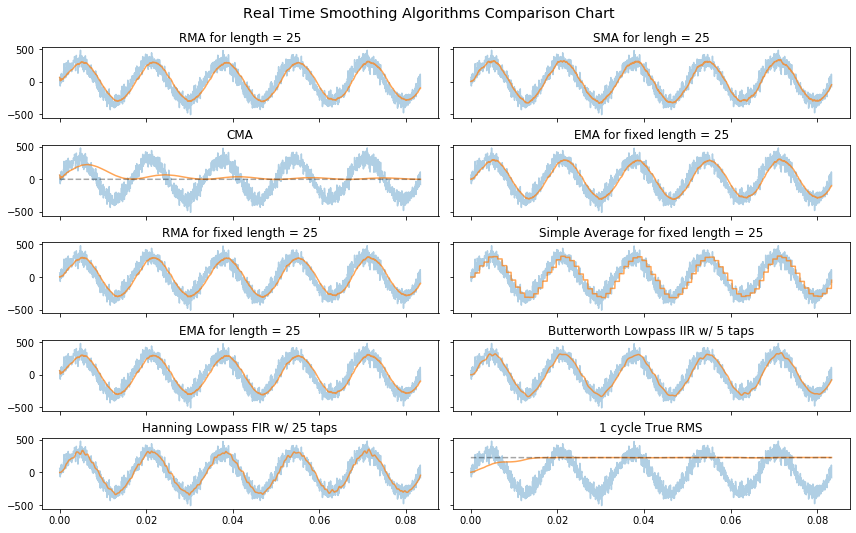

In [48]:
def ALL_test():
    import random
    random.seed(1234)

    # generate sin wave data
    periods = 5
    amplitude = 220*np.sqrt(2)
    frequency = 60
    duration = periods / frequency
    noise_percentage = (20/100)*amplitude
    sample_frequency=24000
    ydata = tonegen(frequency, duration, amplitude, sample_frequency)
    xdata = np.linspace(0., ydata.size / sample_frequency, ydata.size)
    # add noise to the data
    ydata += np.random.normal(0, noise_percentage, len(ydata))

    output_RMA = np.zeros(len(xdata))
    output_fixed_length_RMA = np.zeros(len(xdata))
    output_SMA = np.zeros(len(xdata))
    output_CMA = np.zeros(len(xdata))
    compute_CMA(0, reset=True)
    output_EMA = np.zeros(len(xdata))
    output_fixed_length_EMA = np.zeros(len(xdata))
    output_simple_average = np.zeros(len(xdata))
    output_FIR = np.zeros(len(xdata))
    output_IIR = np.zeros(len(xdata))
    output_true_RMS_1 = np.zeros(len(xdata))
    length = 25

    FIR_numtaps = 25
    IIR_numtaps = 5
    
    compute_FIR(0, reset=True)
    compute_IIR(0, reset=True)
    compute_true_RMS(0, reset=True)
    for i, y in enumerate(ydata):
        output_true_RMS_1[i] = compute_true_RMS(y, 1*24000/60)
        output_FIR[i] = compute_FIR(y)
        output_IIR[i] = compute_IIR(y)
        output_RMA[i] = compute_RMA(y, length)
        output_fixed_length_RMA[i] = compute_fixed_length_RMA(y, length)
        output_SMA[i] = compute_SMA(y, length)
        output_CMA[i] = compute_CMA(y)
        output_EMA[i] = compute_EMA(y, length)
        output_fixed_length_EMA[i] = compute_fixed_length_EMA(y, length)
        output_simple_average[i] = compute_simple_average(y, length)
        
            
    alpha=0.7
    fig, ax = plt.subplots(5, 2, figsize=(12,8), sharex=True, sharey=True)
    st = fig.suptitle(f"Real Time Smoothing Algorithms Comparison Chart", fontsize="x-large")
    ax[0][0].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[0][0].plot(xdata, output_RMA, alpha=alpha, label=f"RMA for length = {length}")
    ax[0][0].set_title(f"RMA for length = {length}")
    
    ax[1][0].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[1][0].plot(xdata, output_CMA, alpha=alpha, label=f"CMA")
    ax[1][0].plot(xdata, np.zeros(len(ydata)), 'k--', alpha=0.5*alpha)
    ax[1][0].set_title(f"CMA")

    ax[2][0].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[2][0].plot(xdata, output_fixed_length_RMA, alpha=alpha, label=f"RMA for fixed length = {length}")
    ax[2][0].set_title(f"RMA for fixed length = {length}")
    
    ax[3][0].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[3][0].plot(xdata, output_EMA, alpha=alpha, label=f"EMA for length = {length}")
    ax[3][0].set_title(f"EMA for length = {length}")

    ax[4][0].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[4][0].plot(xdata, output_FIR, alpha=alpha, label=f"Hanning Lowpass FIR w/ {FIR_numtaps} taps")
    ax[4][0].set_title(f"Hanning Lowpass FIR w/ {FIR_numtaps} taps")

    ax[0][1].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[0][1].plot(xdata, output_SMA, alpha=alpha, label=f"SMA for lengh = {length}")
    ax[0][1].set_title(f"SMA for lengh = {length}")

    ax[1][1].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[1][1].plot(xdata, output_fixed_length_EMA, alpha=alpha, label=f"EMA for fixed length = {length}")
    ax[1][1].set_title(f"EMA for fixed length = {length}")

    ax[2][1].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[2][1].plot(xdata, output_simple_average, alpha=alpha, label=f"Simple Average for fixed length = {length}")
    ax[2][1].set_title(f"Simple Average for fixed length = {length}")

    ax[3][1].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[3][1].plot(xdata, output_IIR, alpha=alpha, label=f"Butterworth Lowpass IIR w/ {IIR_numtaps} taps")
    ax[3][1].set_title(f"Butterworth Lowpass IIR w/ {IIR_numtaps} taps")
    
    ax[4][1].plot(xdata, ydata, alpha=0.5*alpha, label="original data")
    ax[4][1].plot(xdata, output_true_RMS_1, alpha=alpha, label=f"1 cycle True RMS")
    ax[4][1].plot(xdata, true_RMS(ydata)*np.ones(len(ydata)), 'k--', alpha=0.5*alpha)
    ax[4][1].set_title(f"1 cycle True RMS")
    
    fig.tight_layout()
    # shift subplots down:
    st.set_y(0.92)
    fig.subplots_adjust(top=0.85)
    plt.show()
    
ALL_test()